# Completion profiling

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Function to profile

In [2]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
               for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0])
                for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

## Data

In [3]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [4]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [5]:
import random
sample1000 = random.sample(list_titles, 1000)
with open("sample1000.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(sample1000))

## cProfile

In [6]:
import cProfile, io, pstats, os

def toprofile0(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))

def doprofile(lines, filename):
    pr = cProfile.Profile()
    pr.enable()
    toprofile0(lines)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
    res = s.getvalue().replace(rem, "")
    ps.dump_stats(filename)
    return res

In [8]:
r = doprofile(sample1000, "completion.prof")
print(r)

         1232193 function calls in 1.492 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.492    1.492 <ipython-input-6-ff8ba7222a38>:3(toprofile0)
        1    0.000    0.000    1.492    1.492 <ipython-input-2-1cd63cc92e3c>:3(gain_dynamique_moyen_par_mot)
        1    0.150    0.150    1.109    1.109 \src\mlstatpy\nlp\completion.py:418(precompute_stat)
    15320    0.457    0.000    0.827    0.000 \src\mlstatpy\nlp\completion.py:489(merge_completions)
        1    0.059    0.059    0.255    0.255 \src\mlstatpy\nlp\completion.py:453(update_stat_dynamic)
    15320    0.205    0.000    0.209    0.000 {built-in method builtins.__build_class__}
    16319    0.073    0.000    0.123    0.000 \src\mlstatpy\nlp\completion.py:541(update_dynamic_minimum_keystroke)
        1    0.058    0.058    0.095    0.095 \src\mlstatpy\nlp\completion.py:205(build)
    34513    0.087    0.000    0.094    0.000 \sr

## memory_profiler

See [memory_profiler](https://pypi.python.org/pypi/memory_profiler/0.41).

In [9]:
from memory_profiler import profile
%load_ext memory_profiler

In [11]:
%memit toprofile0(sample1000)

peak memory: 349.62 MiB, increment: 15.51 MiB


In [12]:
from io import StringIO
st = StringIO()
@profile(stream=st)
def toprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))
toprofile(sample1000)

ERROR: Could not find file <ipython-input-12-7e3f7b9a5136>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.


In [13]:
%%file temp_mem_profile.py

from mlstatpy.nlp.completion import CompletionTrieNode
from memory_profiler import profile

@profile(precision=4)
def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
               for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0])
                for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

@profile(precision=4)
def toprofile():
    with open("sample1000.txt", "r", encoding="utf-8") as f:
        lines = [_.strip("\n\r ") for _ in f.readlines()]
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))
toprofile()

Overwriting temp_mem_profile.py


In [14]:
import sys
cmd = sys.executable
from pyquickhelper.loghelper import run_cmd
cmd += " -m memory_profiler temp_mem_profile.py"
out, err = run_cmd(cmd, wait=True)
print(out)

Filename: temp_mem_profile.py

Line #    Mem usage    Increment   Line Contents
     5  26.0820 MiB   0.0000 MiB   @profile(precision=4)
     6                             def gain_dynamique_moyen_par_mot(queries, weights):
     7  26.0977 MiB   0.0156 MiB       per = list(zip(weights, queries))
     8  26.0977 MiB   0.0000 MiB       total = sum(weights) * 1.0
     9  26.0977 MiB   0.0000 MiB       res = []
    10  33.4883 MiB   7.3906 MiB       trie = CompletionTrieNode.build([(None, q) for _, q in per])
    11  41.8125 MiB   8.3242 MiB       trie.precompute_stat()
    12  46.7109 MiB   4.8984 MiB       trie.update_stat_dynamic()
    13  46.8750 MiB   0.1641 MiB       wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    14  46.9570 MiB   0.0820 MiB       wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
    15  46.9570 MiB   0.0000 MiB                  for p, w in per]
    16  47.0391 MiB   0.0820 MiB       wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keys

## gprof2dot

See [gprof2dot](https://github.com/jrfonseca/gprof2dot).

In [27]:
import gprof2dot
import sys
sys.argv=["", "-f", "pstats", "completion.prof", "-o", "completion.dot"]
gprof2dot.main()

In [29]:
from pyquickhelper.helpgen.conf_path_tools import find_graphviz_dot
dot = find_graphviz_dot()

In [34]:
from pyquickhelper.loghelper import run_cmd
out, err = run_cmd('"{0}" completion.dot -Tpng -ocompletion.png'.format(dot), wait=True)
print(out)

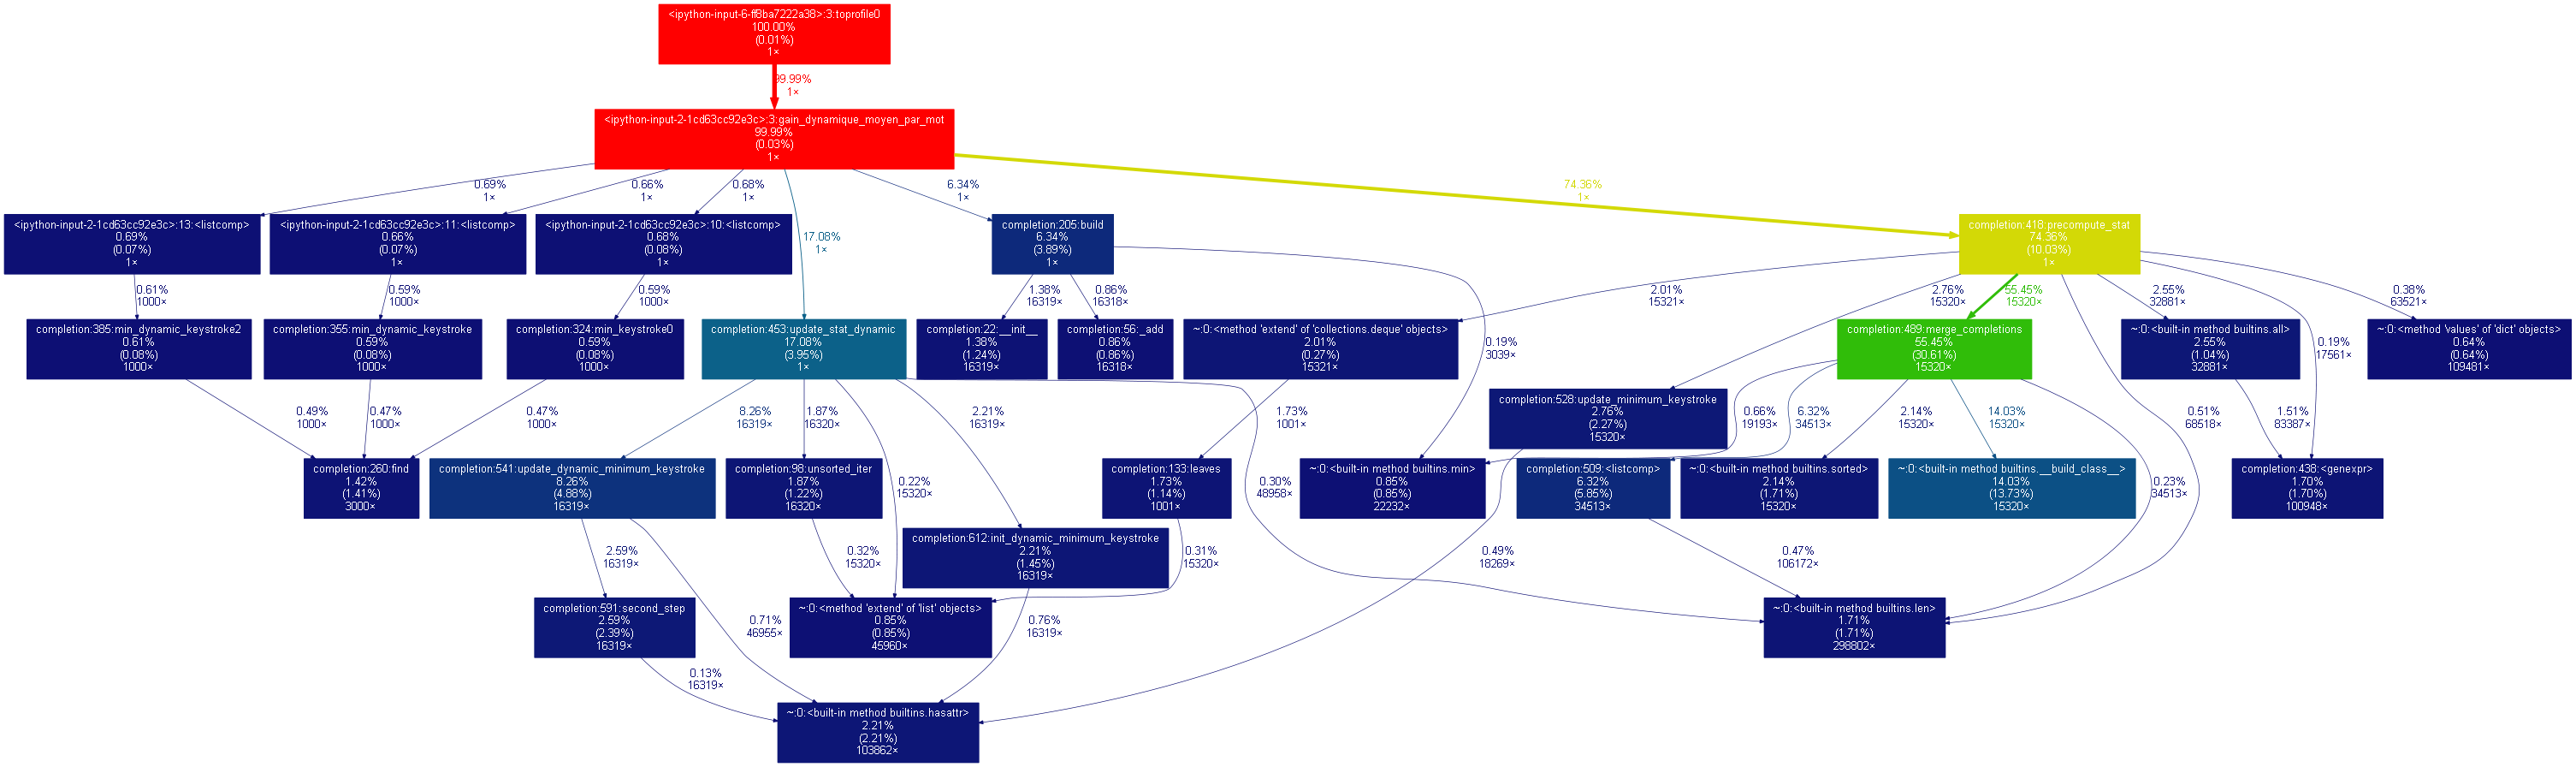

In [35]:
from IPython.display import Image
Image("completion.png")

## pyinstrument

See [pyinstrument](https://github.com/joerick/pyinstrument).

In [36]:
from pyinstrument import Profiler

profiler = Profiler(use_signal=False)
profiler.start()

toprofile0(sample1000)

profiler.stop()

print(profiler.output_text(unicode=True, color=True))

4.613 gain_dynamique_moyen_par_mot  <ipython-input-2-1cd63cc92e3c>:3
├─ 2.765 precompute_stat  mlstatpy\nlp\completion.py:418
│  ├─ 1.824 merge_completions  mlstatpy\nlp\completion.py:489
│  │  └─ 0.307 <listcomp>  mlstatpy\nlp\completion.py:509
│  ├─ 0.108 update_minimum_keystroke  mlstatpy\nlp\completion.py:528
│  ├─ 0.100 <genexpr>  mlstatpy\nlp\completion.py:438
│  └─ 0.096 leaves  mlstatpy\nlp\completion.py:133
├─ 1.544 update_stat_dynamic  mlstatpy\nlp\completion.py:453
│  ├─ 0.867 update_dynamic_minimum_keystroke  mlstatpy\nlp\completion.py:541
│  │  └─ 0.301 second_step  mlstatpy\nlp\completion.py:591
│  ├─ 0.147 unsorted_iter  mlstatpy\nlp\completion.py:98
│  └─ 0.059 init_dynamic_minimum_keystroke  mlstatpy\nlp\completion.py:612
└─ 0.174 build  mlstatpy\nlp\completion.py:205
   └─ 0.058 __init__  mlstatpy\nlp\completion.py:22



## SnakeViz

In [37]:
%load_ext snakeviz

L'instruction qui suit lance l'explorateur par défaut avec les données du profilage.

In [38]:
# %snakeviz toprofile(sample1000)

## line_profiler

See [line_profiler](https://github.com/rkern/line_profiler).

In [39]:
def lineprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))

In [40]:
from mlstatpy.nlp.completion import CompletionTrieNode

In [41]:
from line_profiler import LineProfiler
prof = LineProfiler()
prof.add_function(gain_dynamique_moyen_par_mot)
prof.add_function(CompletionTrieNode.precompute_stat)
prof.run("lineprofile(sample1000)")
st = io.StringIO()
prof.print_stats(stream=st)
rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
res = st.getvalue().replace(rem, "")
print(res)

Timer unit: 4.27635e-07 s

Total time: 4.98794 s
File: <ipython-input-2-1cd63cc92e3c>
Function: gain_dynamique_moyen_par_mot at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def gain_dynamique_moyen_par_mot(queries, weights):
     4         1          779    779.0      0.0      per = list(zip(weights, queries))
     5         1           44     44.0      0.0      total = sum(weights) * 1.0
     6         1            8      8.0      0.0      res = []
     7         1       661721 661721.0      5.7      trie = CompletionTrieNode.build([(None, q) for _, q in per])
     8         1      8560782 8560782.0     73.4      trie.precompute_stat()
     9         1      2136270 2136270.0     18.3      trie.update_stat_dynamic()
    10         1        97001  97001.0      0.8      wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    11         1           21     21.0      0.0      wks_dyn = [(w, p, len(w) -